In [1]:
# Standard lib imports
from typing import Union, Tuple, Callable, Any

# Third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from IPython.display import display

In [2]:
DATA_PATH = '../data/telco.csv'

In [3]:
df_churn = pd.read_csv(DATA_PATH)
df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# .T transposes the entire dataset
print(df_churn.head().T)
print(df_churn.shape)

                                 0             1               2  \
customerID              7590-VHVEG    5575-GNVDE      3668-QPYBK   
gender                      Female          Male            Male   
SeniorCitizen                    0             0               0   
Partner                        Yes            No              No   
Dependents                      No            No              No   
tenure                           1            34               2   
PhoneService                    No           Yes             Yes   
MultipleLines     No phone service            No              No   
InternetService                DSL           DSL             DSL   
OnlineSecurity                  No           Yes             Yes   
OnlineBackup                   Yes            No             Yes   
DeviceProtection                No           Yes              No   
TechSupport                     No            No              No   
StreamingTV                     No            No

In [5]:
def string_transformations(
    target: Union[pd.core.strings.accessor.StringMethods, pd.core.indexes.base.Index]
) -> Union[pd.core.series.Series, pd.core.indexes.base.Index]:
    """
        Stage 1 cleaning for this churn prediction:
        - Lower case for everything
        - Spaces replaced by underscores

        Can work on either Pandas indices (e.g. column headers) or Pandas series (e.g. row data)
        
        :param StringMethods | Index target: the target row or column to standardise
        :return StringMethods | Index result: the standardised row or column

        Note the return types are using typing since this was written pre-3.10.
    """
    result = (
        target
        .str
        .lower()
        .str
        .replace(' ', '_')
    )

    return result

In [6]:
# Fix lack of consistency in columns
def standardise_strings(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()
    df_new.columns = string_transformations(target=df_new.columns)

    object_filter = df_new.dtypes == type(object)

    categorical_columns = list(df_new.dtypes[object_filter].index)
    df_new[categorical_columns] = df_new[categorical_columns].apply(func=string_transformations, axis=1)
    return df_new

def standardise_float(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    new_col = pd.to_numeric(df[col_name], errors='coerce')

    df_new = df.copy()
    df_new[col_name] = new_col.fillna(0)

    return df_new

def encode_labels(df: pd.DataFrame, col_name: str, encode_value: str) -> pd.DataFrame:
    new_col = (df[col_name] == encode_value).astype(int)

    df_new = df.copy()
    df_new[col_name] = new_col

    return df_new

In [7]:
df_churn_standardised = standardise_strings(df_churn)

In [8]:
df_fixed_charges = standardise_float(df=df_churn_standardised, col_name='totalcharges')
df_encoded_labels = encode_labels(df=df_fixed_charges, col_name='churn', encode_value='yes')

In [9]:
# Using scikit-learn - no need to write this custom anymore like in the other follow-along!
df_full_train, df_test = train_test_split(df_encoded_labels, test_size=0.2, random_state=1)

# But this splits into just train (80%) and test (20%). This needs another split for validation component.
# To split the training set again and end up with train (60%), validation (20%), test (20%)
# This requires a split of (.20/.80) = 0.25
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Val and test should be same length
print(f"{len(df_train)=}")
print(f"{len(df_val)=}")
print(f"{len(df_test)=}")

len(df_train)=4225
len(df_val)=1409
len(df_test)=1409


In [10]:
# Time to set up these dataframes for testing/training/validation
# Sort them and separate out the desired label (churn)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['churn'].values
y_val = df_val['churn'].values
y_test = df_test['churn'].values

del df_train['churn']
del df_val['churn']
del df_test['churn']

### EDA
##### Exploratory Data Analysis on the full training dataset

The TL;DR:
- There's no missing values in this data!
- 4k+ non-churning customers (73%)
- 1.5k+ churning customers (27%) <= this is the churn rate

In [11]:
df_full_train = df_full_train.reset_index(drop=True)
df_full_train.isnull().sum()
df_full_train.churn.value_counts()
df_full_train.churn.value_counts(normalize=True) # df_full_train.churn.mean() would also give us the 27% churn rate

0    0.730032
1    0.269968
Name: churn, dtype: float64

In [12]:
numeric_variables = ['tenure', 'monthlycharges', 'totalcharges']
categorical_variables = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [13]:
df_full_train[categorical_variables].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

In [14]:
# Churn rate within different groups (instead of global)
# This will help determine importance of various features
# For example, gender's not really important here - churn rate is very similar for both
global_churn: float = df_full_train.churn.mean()
churn_female: float = df_full_train[df_full_train['gender'] == 'female'].churn.mean()
churn_male: float = df_full_train[df_full_train['gender'] == 'male'].churn.mean()
churn_partner_yes: float = df_full_train[df_full_train['partner'] == 'yes'].churn.mean()
churn_partner_no: float = df_full_train[df_full_train['partner'] == 'no'].churn.mean()

print(f"{global_churn=}")
print(f"{churn_female=}")
print(f"{churn_male=}")
print(f"{churn_partner_no=}")
print(f"{churn_partner_yes=}")

global_churn=0.26996805111821087
churn_female=0.27682403433476394
churn_male=0.2632135306553911
churn_partner_no=0.3298090040927694
churn_partner_yes=0.20503330866025166


In [15]:
# This can be used to calculate "risk ratios":
# - Risk = Group or feature churn rate / global churn rate

churn_partner_yes / global_churn

# In reality, this can't be done so line-by-line as above. Use grouping to identify this stuff instead
# Is there a way to do this in a functional way e.g. without a for-loop?
for next_cat in categorical_variables:
    df_full_train_agg = df_full_train.groupby(next_cat).churn.agg(
        ['mean', 'count']
    )
    df_full_train_agg['diff'] = df_full_train_agg['mean'] - global_churn
    df_full_train_agg['risk'] = df_full_train_agg['mean'] / global_churn
    display(df_full_train_agg)

,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


In [16]:
# Calculating mutual information scores
# These give an idea of how much a particular feature affects the churn rate.
mutual_info = df_full_train[categorical_variables].apply(lambda series: mutual_info_score(series, df_full_train['churn']))
mutual_info.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

Taking the top 7 mutual info scores, these build a possible feature list:
- `contract`
- `onlinesecurity`
- `techsupport`
- `internetservice`
- `onlinebackup`
- `deviceprotection`
- `paymentmethod`

Correlation can also be used to contribute to feature selection
- `tenure` - negative correlation - when `tenure` goes up, `churn` goes down
- `monthlycharges` - weak positive correlation - when `monthlycharges` goes up, `churn` goes up
- `totalcharges` - weak negative correlation - when `totalcharges` goes up, `churn` goes down (seems weird, but it makes sense that people with longer tenure pay more)

In [17]:
df_full_train[numeric_variables].corrwith(df_full_train['churn'])

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [18]:
# This cell was used to look at a few different churn rates vs. tenure:
# - <= 2 months
# - > 2 months
# - Less than a year
# - Over 1 year
# There was a lot more in the follow-along video but it was just demonstrations that have been left out of this notebook
df_full_train[(df_full_train['tenure'] > 12)]['churn'].mean()

0.17634908339788277

##### Time for One-Hot Encoding!

In [19]:
# scikit-learn has a DictVectorizer that can do this
dict_train = df_train[categorical_variables + numeric_variables].to_dict(orient='records')

In [20]:
vectorizer = DictVectorizer(sparse=False) # to get a numpy array instead of sparse matrix
vectorizer.fit(dict_train)
vectorizer.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [21]:
# No need to do fit/transform separately on training dataset; use fit_transform
X_train = vectorizer.fit_transform(dict_train)
X_train.shape

(4225, 45)

In [22]:
# But for training and validation datasets, just use transform.
# TODO: Turn this into a function to re-use
dict_val = df_val[categorical_variables + numeric_variables].to_dict(orient='records')
X_val = vectorizer.transform(dict_val)

dict_test = df_test[categorical_variables + numeric_variables].to_dict(orient='records')
X_test = vectorizer.transform(dict_test)

##### Time for Logistic Regression!

Despite the name, logistic regression is actually a (binary) classification algorithm.

Not doing a math example yet like in the linear regression notebook - not here to improve Markdown skills right now...

In [23]:
# Implementing a sigmoid function
def sigmoid(z) -> np.ndarray:
    return 1 / (1 + np.exp(-z))

[-5.  -4.8 -4.6 -4.4 -4.2 -4.  -3.8 -3.6 -3.4 -3.2 -3.  -2.8 -2.6 -2.4
 -2.2 -2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4
  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3.   3.2
  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5. ]


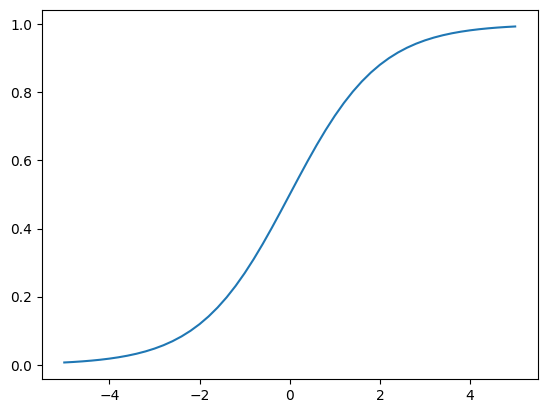

In [24]:
z = np.linspace(-5, 5, 51)
print(z)
type(sigmoid(z))
plt.plot(z, sigmoid(z))

In [25]:
# Time for logistic regression!
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [26]:
print(f"{model.coef_.round(3)=}") # Weights
print(f"{model.intercept_[0]=}") # Intercept

model.coef_.round(3)=array([[ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
        -0.034, -0.073, -0.335,  0.317, -0.089,  0.004, -0.258,  0.141,
         0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
         0.124, -0.166,  0.058, -0.087, -0.032,  0.07 , -0.059,  0.141,
        -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
         0.213, -0.089, -0.232, -0.07 ,  0.   ]])
model.intercept_[0]=-0.10903897643040907


In [27]:
# Hard predictions - e.g. the label, 0 or 1
print(f"{model.predict(X_train)=}")

# Soft predictions - a probability score between 0 and 1
print(f"{model.predict_proba(X_train)=}")

model.predict(X_train)=array([0, 1, 1, ..., 1, 0, 1])
model.predict_proba(X_train)=array([[0.9044921 , 0.0955079 ],
       [0.32066572, 0.67933428],
       [0.36632215, 0.63367785],
       ...,
       [0.46836724, 0.53163276],
       [0.95746889, 0.04253111],
       [0.30127352, 0.69872648]])


In [28]:
# Using predict_proba because this can be used to set a threshold for deciding if prediction is a "true" churn or not.
# The default behaviour via model.predict would be anything > 0.5.
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.0089955 , 0.20450854, 0.21220545, ..., 0.13638204, 0.79977182,
       0.83740925])

In [29]:
churn_decision = (y_pred > 0.5)
print(f"{churn_decision=}")
df_val[churn_decision]

churn_decision=array([False, False, False, ..., False,  True,  True])


,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
3,8433-wxgna,male,0,no,no,2,yes,no,fiber_optic,yes,no,no,no,no,no,month-to-month,yes,electronic_check,75.70,189.20
8,3440-jpscl,female,0,no,no,6,yes,no,fiber_optic,no,no,yes,yes,yes,yes,month-to-month,yes,mailed_check,99.95,547.65
11,2637-fkfsy,female,0,yes,no,3,yes,no,dsl,no,no,no,no,no,no,month-to-month,yes,mailed_check,46.10,130.15
12,7228-omtpn,male,0,no,no,4,yes,no,fiber_optic,no,no,no,no,yes,yes,month-to-month,yes,electronic_check,88.45,370.65
19,6711-fldfb,female,0,no,no,7,yes,yes,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,74.90,541.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,5976-jcjrh,male,0,yes,no,10,yes,no,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,70.30,738.20
1398,2034-cgrhz,male,1,no,no,24,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,month-to-month,yes,credit_card_(automatic),102.95,2496.70
1399,5276-kqwhg,female,1,no,no,2,yes,no,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,69.60,131.65
1407,6521-yytyi,male,0,no,yes,1,yes,yes,fiber_optic,no,no,no,no,yes,yes,month-to-month,yes,electronic_check,93.30,93.30


In [30]:
# Linear regression uses RMSE to evaluate the effectiveness of the model
# For logistic regression it's slightly different...? Using mean of predictions vs. actual labels in validation set to get an accuracy score?
(y_val == churn_decision).mean()

0.8034066713981547

In [31]:
# Can do a comparison by literally setting the proba/predict/actual in a dataframe
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val
df_pred['correct'] = df_pred['prediction'] == df_pred['actual']
df_pred

,probability,prediction,actual,correct
0,0.008996,0,0,True
1,0.204509,0,0,True
2,0.212205,0,0,True
3,0.543047,1,1,True
4,0.213768,0,0,True
...,...,...,...,...
1404,0.313635,0,0,True
1405,0.039354,0,1,False
1406,0.136382,0,0,True
1407,0.799772,1,1,True


In [32]:
df_pred.correct.mean()

0.8034066713981547

##### What does it all mean?

In [33]:
# Zip together feature names and coefficients so it's easier to show the weights per feature in a digestible format
dict(zip(vectorizer.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.124,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.07,
 

In [34]:
# TODO: Turn this into smaller, digestible bits with re-usable functions
# Use a smaller feature set this time around to interpret the model a bit better
small_feature_set = ['contract', 'tenure', 'monthlycharges']
dict_train_small = df_train[small_feature_set].to_dict(orient='records')
dict_val_small = df_val[small_feature_set].to_dict(orient='records')

vectorizer_small = DictVectorizer(sparse=False)
vectorizer_small.fit(dict_train_small)

DictVectorizer(sparse=False)

In [35]:
print(f"{vectorizer_small.get_feature_names_out()=}")

X_train_small = vectorizer_small.transform(dict_train_small)
model_small = LogisticRegression()
model_small.fit(X_train_small, y_train)

vectorizer_small.get_feature_names_out()=array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)


LogisticRegression()

In [36]:
dict(zip(vectorizer_small.get_feature_names_out(), model_small.coef_[0].round(3)))

{'contract=month-to-month': 0.97,
 'contract=one_year': -0.025,
 'contract=two_year': -0.949,
 'monthlycharges': 0.027,
 'tenure': -0.036}

In [37]:
# Skipped a lot of the model interpretation stuff in the video - back to the big model and training it on the full dataset
dict_full_train = df_full_train[categorical_variables + numeric_variables].to_dict(orient="records")

In [38]:
full_vectorizer = DictVectorizer(sparse=False)
X_full_train = full_vectorizer.fit_transform(dict_full_train)
y_full_train = df_full_train.churn.values

final_model = LogisticRegression()
final_model.fit(X_full_train, y_full_train)

LogisticRegression()

In [39]:
dicts_test = df_test[categorical_variables + numeric_variables].to_dict(orient="records")
X_test = full_vectorizer.transform(dicts_test)

In [40]:
y_test_pred = final_model.predict_proba(X_test)[:, 1]
churn_decision = (y_test_pred > 0.5)

378.64446280989824

In [42]:
(churn_decision == y_test).mean()

0.815471965933286

##### Time to dive into using the model!

In [50]:
customer = dict_test[-1]
X_sample = full_vectorizer.transform([customer])
final_model.predict_proba(X_sample)[0, 1] # Probably not going to churn

0.5968852088266045

In [49]:
# Actual value
y_test[-1]

1